# Masques nuages sur les données Sentinel S2


## Fichier CLM_BAND

Création d’un masque de nuages à partir des fichiers CLM_BAND, c’est un fichier Geotiff produit par THEIA avec des valeurs de type Entier non signé 8 bits. 
Deux résolutions sont disponibles: 10m et 20m. 


Voici la documentation officielle qui indique la signification des 8 bits.

bit 0 (1) : Tous nuages (sauf les plus fins), et toutes les ombres.

bit 1 (2) : Tous nuages (sauf les plus fins).

bit 2 (4) : Nuages détectés par seuil absolu dans le bleu.

bit 3 (8) : Nuages détectés par seuil multi-temporel.

bit 4 (16) : Nuages très fins.

bit 5 (32) : Ombres de nuages correspondant à un nuage. 

bit 6 (64) : Ombres de nuages détectés dans la zone où les nuages pourraient être hors image (moins fiable).

bit 7 (128) : Nuages hauts détectés par la bande 1.38 µm.


## Utilisation avec Python et rasterio

### Chargement des données raster

In [18]:
# Chargement des modules
from os import listdir
from os.path import join
import rasterio
import numpy as np
import fiona


In [19]:
# liste des données (*.TIF)
# dans data/LC08_L1TP_228056_20130714_20200912_02_T1
d_data = "/home/fouzai/Bureau/maja_sentinel2/21NZG/SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0/"
d_img = "MASKS"
tif_files = [f for f in listdir(join(d_data, d_img)) if f.endswith(".tif")]
tif_files


['SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0_EDG_R1.tif',
 'SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0_MG2_R1.tif',
 'SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0_IAB_R2.tif',
 'SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0_CLM_R1.tif',
 'SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0_EDG_R2.tif',
 'SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0_IAB_R1.tif',
 'SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0_MG2_R2.tif',
 'SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0_CLM_R2.tif',
 'SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0_SAT_R2.tif',
 'SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0_SAT_R1.tif']

In [36]:
d_band="SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0_FRE"
f_b2 = join(d_data, d_band + '_B2.tif')
f_b3 = join(d_data, d_band + '_B3.tif')
f_b4 = join(d_data, d_band + '_B4.tif')


f_clm_pixel = join(d_data, d_img, "SENTINEL2A_20200911-141100-719_L2A_T21NZG_C_V1-0" + '_CLM_R1.tif')

f_clm_pixel = rasterio.open(f_clm_pixel)

f_clm_pixel.count, f_clm_pixel.width, f_clm_pixel.height, f_clm_pixel.bounds, f_clm_pixel.dtypes, f_clm_pixel.crs

(1,
 10980,
 10980,
 BoundingBox(left=799980.0, bottom=590220.0, right=909780.0, top=700020.0),
 ('uint8',),
 CRS.from_epsg(32621))

### Quelles sont les valeurs présentes dans la bande CLM_BAND_Pixels ?

In [21]:
band_clm = f_clm_pixel.read(1)
for value in np.unique(band_clm):
    print(f'{value:0>8b} ({value})')


00000000 (0)
00000001 (1)
00000011 (3)
00000111 (7)
00001011 (11)
00001111 (15)
00010011 (19)
00011011 (27)
00011111 (31)
00100001 (33)
00100011 (35)
00101011 (43)
00101111 (47)
00110011 (51)
00111011 (59)
00111111 (63)
01000001 (65)
01001011 (75)
01100001 (97)
01101011 (107)


In [22]:
import matplotlib.pyplot as plt
# pour plotter autour de St Laurent : 
# quelle plage de pixel contient St-Laurent ?
x_utm21, y_utm21 = (827400, 608350)
row, col = f_clm_pixel.index(x_utm21, y_utm21)
row, col


(9167, 2742)

### Application du masque v1: nuages =tous nuages (bit 1) sauf les plus fins

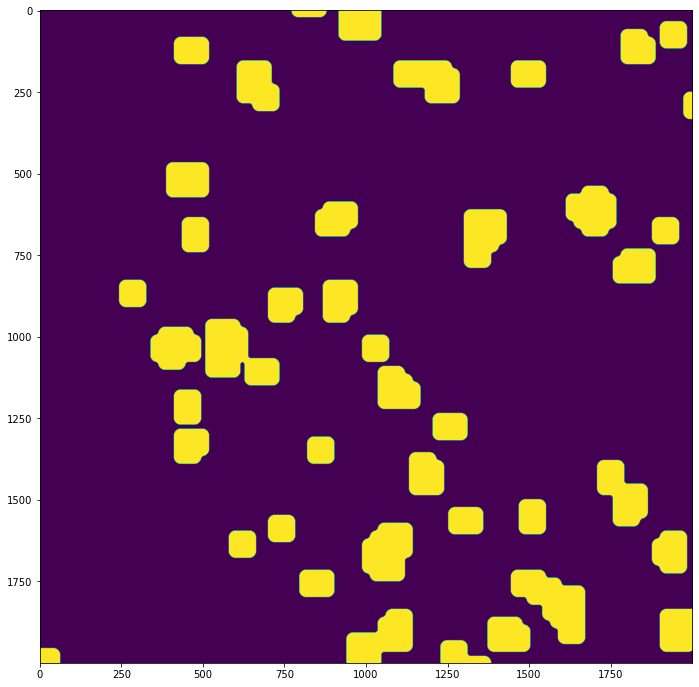

In [29]:
# bit 1 2 3
compare_mask_sans = 0b00000010
clouds_v1 = (np.bitwise_and(band_clm, compare_mask_sans) > 0)
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(clouds_v1[8000:10000,4000:6000])


In [31]:
# sauvegarde du masque
kwds = f_clm_pixel.profile
kwds['driver'] = 'GTiff'
kwds['dtype'] = 'uint8'
kwds['nodata'] = 255
kwds

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32621), 'transform': Affine(10.0, 0.0, 799980.0,
       0.0, -10.0, 700020.0), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}

### Application du masque v2: nuages >= tous nuages + ombres de nuage : (bit 0)

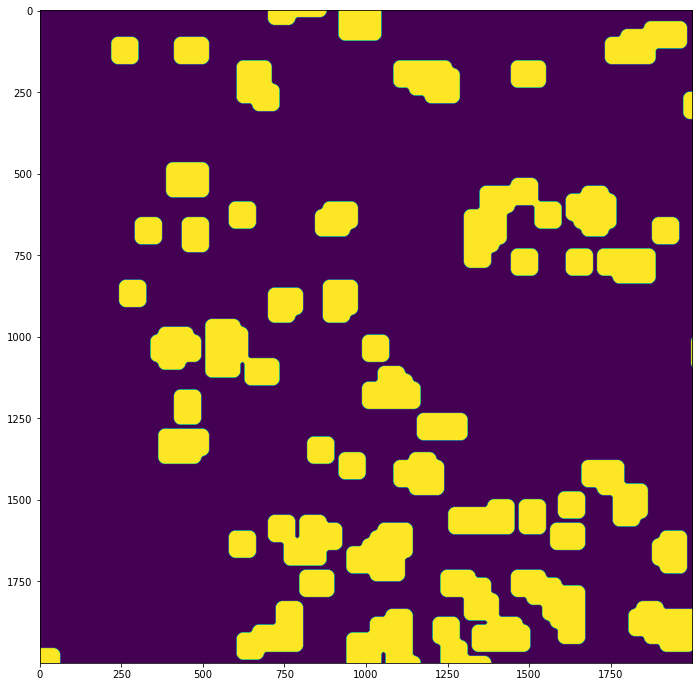

In [41]:
# bit 1 2 3 9
compare_mask_avec = 0b00000001
clouds_v2 = (np.bitwise_and(band_clm, compare_mask_avec) > 0)
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(clouds_v2[8000:10000,4000:6000])


### Exporter le masque de nuage sous format Geotiff 

In [ ]:
f_clouds_v2 = join('/home/fouzai/Bureau/', 'clouds_v2.tif')
with rasterio.open(f_clouds_v2, 'w', **kwds) as r_output:
    r_output.write(clouds_v2)

### Application du masque : ombre des nuages (bit 5 + bit 6)

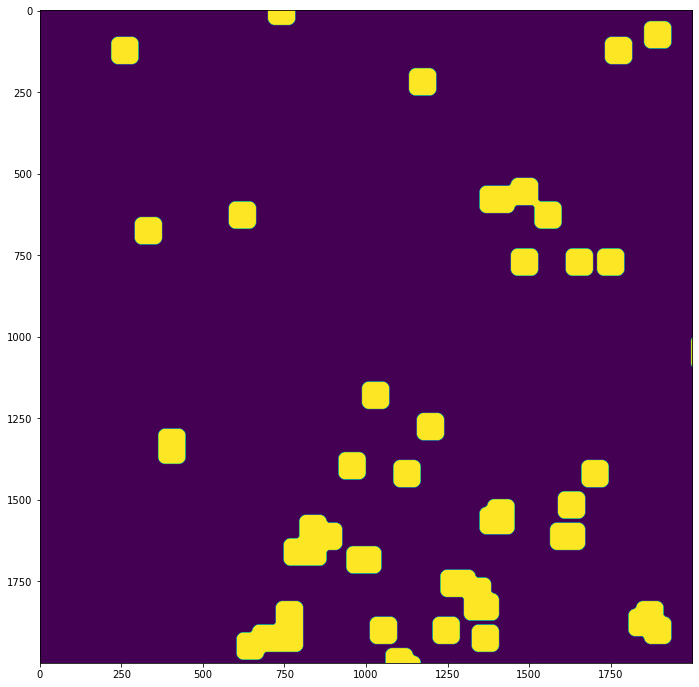

In [34]:
# bit 1 9 11
compare_mask_ombre= 0b01100000
shadows = (np.bitwise_and(band_clm, compare_mask_ombre) > 0)
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(shadows[8000:10000,4000:6000])


### Exporter le masque ombre de nuage sous format Geotiff

In [55]:
f_shadows = join('output', 'shadows.tif')
with rasterio.open(f_shadows, 'w', **kwds) as r_output:
    r_output.write(shadows, 1)

### Afficher le raster

In [37]:
# bandes 2,3 et 4
r_b2 = rasterio.open(f_b2)
r_b3 = rasterio.open(f_b3)
r_b4 = rasterio.open(f_b4)



In [38]:
# stack bands
band_2 = r_b2.read(1)
band_3 = r_b3.read(1)
band_4 = r_b4.read(1)


### Application du masque v1: nuages >= tous nuages sauf les plus fin (bit 1) + ombres de nuage (bit 5 et bit 6)

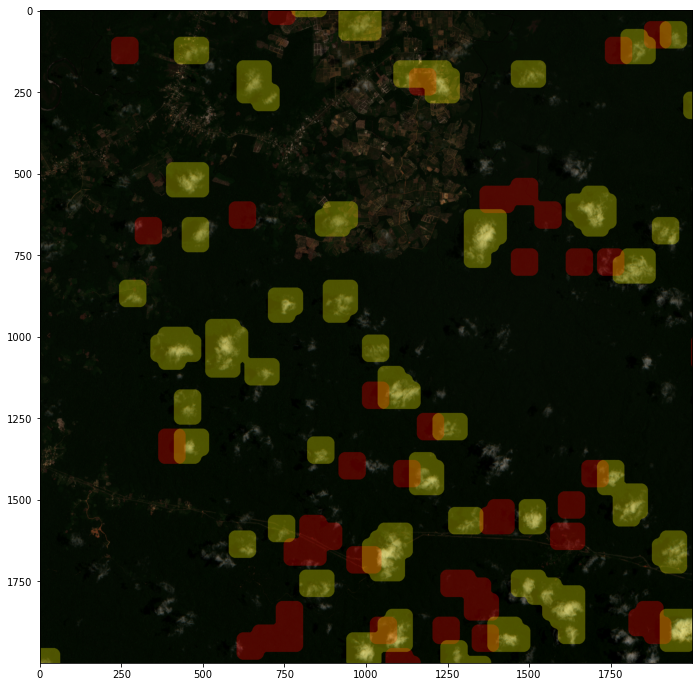

In [39]:
def plot_masked_rgb(red, green, blue, mask, color_mask=(1, 0, 0), transparency=0.5, brightness=2):
    
    # to improve our visualization, we will increase the brightness of our values
    red = red / red.max() * brightness
    green = green / green.max() * brightness
    blue = blue / blue.max() * brightness
    
    red = np.where(mask==True, red*transparency+color_mask[0]*(1-transparency), red)
    green = np.where(mask==True, green*transparency+color_mask[1]*(1-transparency), green)
    blue = np.where(mask==True, blue*transparency+color_mask[2]*(1-transparency), blue)
    
    rgb = np.stack([red, green, blue], axis=2)
    
    return rgb
                

rgb = plot_masked_rgb(band_4, band_3, band_2, shadows, color_mask=(1, 0, 0), transparency=0.7, brightness=2)
rgb = plot_masked_rgb(rgb[..., 0], rgb[..., 1], rgb[..., 2], clouds_v1, color_mask=(1, 1, 0), transparency=0.7, brightness=2)

plt.figure(figsize=(12,12))
plt.imshow(rgb[8000:10000,4000:6000, 0:3])

### Application du masque v2: nuages >= tous nuages + ombres de nuage : (bit 0)

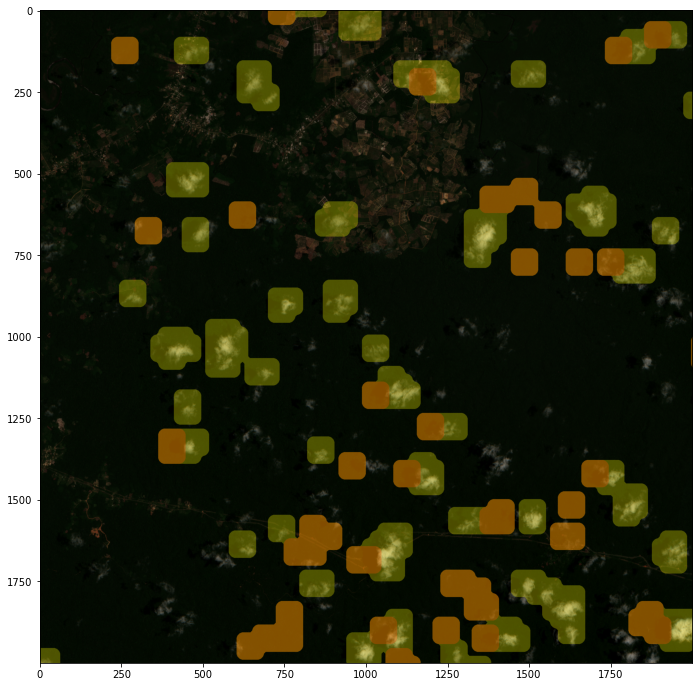

In [40]:

rgb = plot_masked_rgb(band_4, band_3, band_2, shadows, color_mask=(1, 0, 0), transparency=0.7, brightness=2)
rgb = plot_masked_rgb(rgb[..., 0], rgb[..., 1], rgb[..., 2], clouds_v2, color_mask=(1, 1, 0), transparency=0.7, brightness=2)

plt.figure(figsize=(12,12))
plt.imshow(rgb[8000:10000,4000:6000, 0:3])